# **png2png** - mix two images / morphing animation between images

#### Used libraries: [Stable Diffusion](https://https://github.com/CompVis/stable-diffusion) / [imaginAIry](https://github.com/brycedrennan/imaginAIry). See their licenses for copyright terms. Following code licensed under AGPLv3.
###### Copyright (c) 2022 Dorofeev Alexandr


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1c17a0b7-6098-44f9-c77d-3364c45f73b1)


In [ ]:
#@title Press run. Wait til instance restart and then press on the next cell
%%capture
!pip install git+https://github.com/iVoider/imaginAIry.git pillow --upgrade
!pip uninstall -y torchtext 

import os
os.kill(os.getpid(), 9)

In [6]:
#@title Setup

from contextlib import nullcontext

from imaginairy.api import load_model
from PIL import Image
from PIL.Image import Resampling
from io import BytesIO
import requests

import torch
from torch import autocast

from imaginairy.img_utils import pillow_img_to_model_latent
from imaginairy.utils import get_device
from imaginairy.vendored import k_diffusion as K
from imaginairy.modules.find_noise import find_noise_for_image, from_noise


from imaginairy.samplers.base import get_sampler
from imaginairy.schema import ImaginePrompt, ImagineResult

from imaginairy import imagine, imagine_image_files, ImaginePrompt, WeightedPrompt, LazyLoadingImage

from einops import rearrange

from pytorch_lightning import seed_everything

import numpy as np

from pathlib import Path

import glob

import os
import subprocess
from IPython.display import HTML, display
from base64 import b64encode

import uuid

def prepare_images(frames_path, links, prompts, autogenerate_prompts = False):

  def crop_image(image):
    width, height = image.size
    if width == height:
        return image
    offset  = int(abs(height-width)/2)
    if width>height:
        image = image.crop([offset,0,width-offset,height])
    else:
        image = image.crop([0,offset,width,height-offset])
    return image

  def get_image(link):
    r = requests.get(link, headers={'User-agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(r.content)).convert('RGB')
    return crop_image(img).resize((512, 512), Resampling.LANCZOS)

  if os.path.isdir(frames_path) and not len(os.listdir(frames_path)) == 0:
    return "Directory is not empty!"
  else:
    os.makedirs(frames_path)
  
  if not links:
    return "Provide images to morph"
  
  images = [get_image(link) for link in links]

  if autogenerate_prompts:
    prompts = [interrogate(image, models=['ViT-L/14']) for image in images]
  elif not prompts:
    return "Provide prompts"

  for img in images:
    thumb = img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
  return images

def finetune_noises(model, images, prompts, noise_restore_steps = 300, noise_restore_prompt_strength = 0.1):
   return [find_noise_for_image(model, img, prompts[i], noise_restore_steps, noise_restore_prompt_strength, True) for i, img in enumerate(images)]

def showcase_noises(noises, prompts, steps = 50, prompt_strength = 1.6):
 text_conds = []
 for i, noise in enumerate(noises):
  for c, f in from_noise([ImaginePrompt(prompt = prompts[i], sampler_type="k_euler", steps=steps, prompt_strength=prompt_strength)], initial_noise_tensor = noise):
    thumb = f.img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
    text_conds.append(c)
 return text_conds

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

def make_video_ffmpeg(frame_dir, output_file_name='output.mp4', frame_filename="frame%06d.jpg", fps=30):
    frame_ref_path = str(frame_dir / frame_filename)
    video_path = str(frame_dir / output_file_name)
    subprocess.call(
        f"ffmpeg -r {fps} -i {frame_ref_path} -vcodec libx264 -crf 10 -pix_fmt yuv420p"
        f" {video_path}".split()
    )
    return video_path

def morph(prompts, initial_text_conds, start, end, num_steps = 10, prompt_strength=1.6, frame_filename_ext = '.jpg', frames_path = '/content/frames/', use_lerp = True):

  output_path = Path(frames_path)

  for i, t in enumerate(np.linspace(0, 1, num_steps)):
    current = slerp(float(t), start, end)
    if use_lerp:
     cond = torch.lerp(initial_text_conds[0], initial_text_conds[1], float(t))
    else:
     cond = slerp(float(t), initial_text_conds[0], initial_text_conds[1])
    for c, f in from_noise([ImaginePrompt(sampler_type="k_euler", steps=50, prompt_strength= prompt_strength)], initial_noise_tensor = current, initial_text_cond = cond):
     f.save(output_path / (f"frame%06d{frame_filename_ext}" % i))
  return make_video_ffmpeg(output_path)

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

model = load_model().half()

#### Experiment with config parametrs to get near exact input. Have fun!

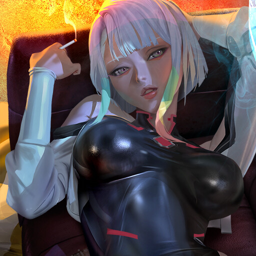

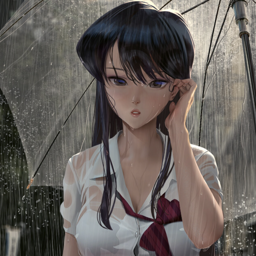

In [3]:
#@title Input data (if you have no idea about prompt - use CLIP Interrogator)
start_image_link = 'https://i.imgur.com/EGf42rQ.jpg ' #@param {type:"string"}
end_image_link = 'https://i.imgur.com/E335tap.png' #@param {type:"string"}
links = [start_image_link, end_image_link]

autogenerate_prompts = False

start_image_prompt = 'a woman in the latex with white hair sitting in a chair with a cigarette in her hand, cyberpunk art, artstation hd, anime aesthetic' #@param {type:"string"}
end_image_prompt = 'a woman in the white shirt with umbrella behind, a detailed painting, photorealism, artstation hd, anime, detailed painting, anime aesthetic' #@param {type:"string"}
prompts = [start_image_prompt, end_image_prompt]

frames_path = '/content/png2png/' + str(uuid.uuid4())

images = prepare_images(frames_path, links, prompts, autogenerate_prompts)

In [4]:
#@title Restore noise

noises = None
noise_restore_steps = 100 #@param {type:"integer"}
noise_restore_prompt_strength = 1 #@param {type:"slider", min:-1, max:1, step:0.1}

noises = finetune_noises(model, images, prompts, noise_restore_steps, noise_restore_prompt_strength)

  0%|          | 0/50 [00:00<?, ?it/s]

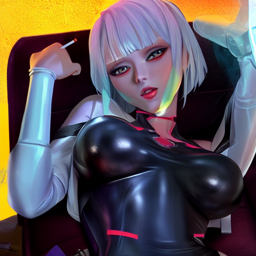

  0%|          | 0/50 [00:00<?, ?it/s]

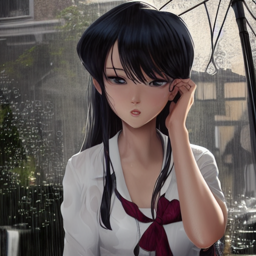

In [7]:
#@title Finetune restoration

steps = 50 #@param {type:"integer"}

prompt_strength = 1.6 #@param {type:"slider", min:0, max:30, step:0.1}

initial_text_conds = showcase_noises(noises, prompts, steps, prompt_strength)

In [8]:
#@title Generate video
%%capture
length = 3 #@param {type:"integer"}
use_lerp = True #@param {type:"boolean"}
video_path = morph(prompts, initial_text_conds, noises[0], noises[1], length, prompt_strength = prompt_strength, frames_path = frames_path, use_lerp = use_lerp)

In [9]:
#@title Show video
visualize_video_colab(video_path)